# Reference

To run this code you will need to install [Matplotlib](https://matplotlib.org/users/installing.html) and [Numpy](https://www.scipy.org/install.html)

If you like to run the example locally follow the instructions provided on [Keras website](https://keras.io/#installation)

It's __strongly__ suggested to use a Python environments manager such as [Conda](https://conda.io/docs/) or some kind of [VirutalEnv](#)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digitalideation/digcre_h2101/blob/master/samples/week06/02-shape-example-cnn.ipynb)

---

# Testing CNN on our shape classifier

Let's try to use a CNN to improve our shape classification model.

We create the dataset _manually_ as we did before. By drawing the shapes with the `draw_shape` function that generat some random shape

In [2]:
%matplotlib inline
import math
import random
import matplotlib.pyplot as plt
import numpy as np

# 0 = rectangle, 1 = triangle, 2 = ellipse
# return shape
def draw_shape(max_size, type):
    
    # Random size and fixed coordinate
#     s = math.floor(random.randrange(1, max_size-4))
#     x = math.floor(max_size/2)
#     y = math.floor(max_size/2)

    # Not so random size and random coordinate
    s = int(random.randrange(max_size/2, max_size))
    x = int(random.randrange(int(s/2), max_size-int(s/2)))
    y = int(random.randrange(int(s/2), max_size-int(s/2)))

    type = type%3
    
    if type == 0:
        art = plt.Rectangle((x-s/2, y-s/2), s, s, color='r')

    if type == 1:
        verts = [
            (x-s/2, y-s/2),
            (x, y+s/2),
            (x+s/2, y-s/2)
        ]
        art = plt.Polygon(verts, color='r')

    if type == 2:
        art = plt.Circle((x, y), s/2, color='r')
    
    return art

We also define a helper function that convert a matplotlib figure to a np array

In [3]:
# https://stackoverflow.com/a/7821917
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

Let's test the function see if it works as expected

(48, 48, 3)


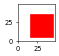

In [13]:
# Image and dataset size we are going to use
image_size = 48
dataset_size = 5000

# Create plot's figure and axes
# https://stackoverflow.com/a/638443
fig = plt.figure(figsize=(1,1), dpi=image_size)
ax = fig.add_subplot(111)

# Setting for the axes
ax.set_xlim(0,image_size)
ax.set_ylim(0,image_size)
# ax.axis('off')

# Draw a random shape
art = draw_shape(image_size,random.randint(0,2))
# Add the shape to the plot
# https://stackoverflow.com/a/29184075
plt.gcf().gca().add_artist(art)
# gcf() means Get Current Figure
# gca() means Get Current Axis

# convert the figure to an array
data = fig2rgb_array(fig)
print(data.shape)

Let's create a loop that will generate a small dataset for us

(500, 48, 48, 3)
(500,)


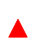

In [14]:
def generate_dataset(image_size, dataset_size):

    # Those variable will contain the images and associated labels
    images = np.zeros((dataset_size, image_size, image_size, 3))
    labels = np.zeros((dataset_size))
    
    # The plot figure we will use to generate the shapes
    fig = plt.figure(figsize=(1,1), dpi=image_size)

    for i in range(dataset_size):
        
        # Clear the figure
        fig.clf()
        
        # Recreate the axes
        ax = fig.add_subplot(111)
        ax.set_xlim(0, image_size)
        ax.set_ylim(0, image_size)
        ax.axis('off')
        
        # Define label
        label = i%3
        art = draw_shape(image_size, label)
        plt.gcf().gca().add_artist(art)
        
        # Add values to the arrays
        images[i] = fig2rgb_array(fig)
        labels[i] = label
        
    return images, labels

# Generate our dataset
images, labels = generate_dataset(image_size, dataset_size)
print(images.shape)
print(labels.shape)

Eventually we can save our dataset for later, since it takes quite some time to generate it 😉

In [24]:
!mkdir datasets
np.save('datasets/shape-example-shapes1.npy', images)
np.save('datasets/shape-example-labels1.npy', labels)

If we need to load it we can then use the following code

In [8]:
images = np.load('datasets/shape-example-shapes1.npy')
labels = np.load('datasets/shape-example-labels1.npy')

We split our dataset manually in training and testing set

(400, 48, 48, 3)
(400,)


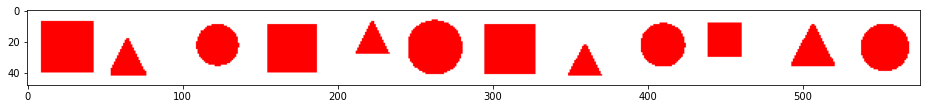

In [15]:
# Define the size of the training set, here we use 80% of the total samples for training
train_size = int(dataset_size*.8)

# TODO: We should shuffle the dataset

# Split the dataset into train and test dataset
train_images, test_images = images[:train_size], images[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# Verify the data
print(train_images.shape)
print(train_labels.shape)

# sample_images = []
# for label, image in list(zip(train_labels, train_images))[:10]:
#     fig1, ax1 = plt.subplots()
#     ax1.axis('off')
#     plt.title(label)
#     fig1.add_subplot(111).imshow(image/255)

full_image = np.concatenate(train_images[:12]/255, axis=1)
plt.figure(figsize=(16,4))
plt.imshow(full_image)

Now we can create our model

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(5, 5), strides=(1,1),
        activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(3, activation='softmax')

])

And compile it

In [17]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

We don't need to reshape our dataset in this case we just scale it so that all values are in the `[0, 1]` interval.

In [18]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

Then we can start the training

In [19]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Train on 400 samples


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

Error: Session cannot generate requests

In [22]:
print('test_acc:', test_acc)

test_acc: 0.9850000143051147


In [ ]:
for label, image in list(zip(test_labels, test_images)):
    prediction = model.predict(np.array([image,]))
    if not prediction.argmax() == label.argmax():
        image = image.reshape(48, 48, 3)
        fig1, ax1 = plt.subplots()
        ax1.axis('off')
        plt.title('predicted:' + str(prediction.argmax()))
        fig1.add_subplot(111).imshow(image)    

Let's test the model with one of our own image

In [ ]:
from tensorflow.keras.preprocessing import image

# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return img, x

In [ ]:
img, x = get_image("assets/photo_rect_red01.jpg")
predictions = netmodelwork.predict(x)
plt.imshow(img)
print(predictions)